## Zestaw 3

### Zadanie 1 

Uczenie CD (ang. Contrastive Divergence).

Zaimplementować samodzielnie (na podstawie wykładu) uczenie typu CD, pisząc procedury przejścia pomiędzy warstwą "wizualną" i ukrytą w sieci RBM. Zamodelować macierz W, wektory h i v oraz proces losowania. Sprawdzić na prostym przykładzie.

- CD (Contrastive Divergence) - jest iteracyjnym algorytmem stosowanym w szkoleniu RBM, które są rodzajem probabilistycznego modelu graficznego używanego do redukcji wymiarowości, uczenia się cech i filtrowania kolaboracyjnego. Podstawowym celem CD jest oszacowanie gradientu funkcji logarytmu wiarygodności powiązanej z RBM.
- RBM (Restricted Boltzman Machine) - składają się z widocznych i ukrytych warstw, w których węzły w warstwach są ze sobą połączone, ale nie mają połączeń w obrębie tej samej warstwy. CD działa poprzez aktualizację wag tych połączeń w celu zminimalizowania różnicy między obserwowanymi danymi a zrekonstruowanymi danymi wygenerowanymi przez RBM.

#### Szkolenie RBM
1. Losowe zainicjowanie wag i odchyleń,
2. Próbka szkoleniowa jest prezentowana RBM, a aktywacje ukrytych jednostek są obliczane przy użyciu bieżących wag i odchyleń,
3. Następnie aktywacje ukrytych jednostek są używane do rekonstrukcji widocznych jednostek, a proces jest powtarzany przez kilka kroków w celu uzyskania zrekonstruowanych widocznych jednostek,
4. Aktualizacje wag i odchyleń są obliczane na podstawie różnicy między oryginalnymi widocznymi jednostkami a zrekonstruowanymi widocznymi jednostkami.

Etapy implementacji:
- Zainicjować parametry modelu RBM (W - wagi, a - widoczne i  b - ukryte warstwy, współczynniki uczenia, liczba epok itp.),
- Obliczanie prawdopodobieństwa ukrytych wag,
- Rekonstrukcja widocznych wag,
- Obliczanie gradientu,
- Aktualizacja wag,
- Powtarzanie procesu aż do osiągnięcia zadowalających wyników.

Prawdopodobieństwa w warstwie ukrytej: [0.57055937 0.48166488 0.47394653]
Rekonstrukcja danych wejściowych: [0.55690357 0.47243672 0.52651428 0.49664054 0.46039233 0.44007432]


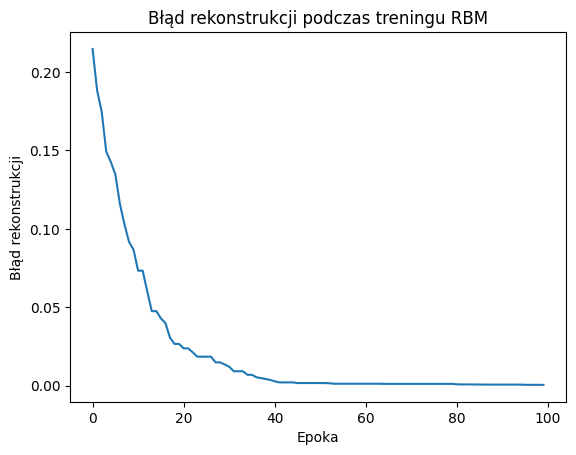

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate # szybkość uczenia

        # Inicjalizacja wag i przesunięć
        self.W = np.random.randn(n_visible, n_hidden) * 0.1
        self.b_visible = np.zeros(n_visible)
        self.b_hidden = np.zeros(n_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x)) # funkcja aktywacji sigmoidalna -> zamienia wyniku na zakres (0, 1)

    def sample_prob(self, probs):
        """Losowanie stanów (0 lub 1) na podstawie prawdopodobieństw."""
        return np.random.binomial(1, probs)

    def train(self, v_input, k=1): # Trenowanie RBM za pomoca algorytmu CD
        # Faza pozytywna
        h_prob = self.sigmoid(np.dot(v_input, self.W) + self.b_hidden) # Obliczamy prawdopodobieństwa w warstwie ukrytej
        h_sample = self.sample_prob(h_prob) # Losujemy stany w warstwie ukrytej
        
        # Faza negatywna (rekonstrukcja)
        for _ in range(k):
            v_reconstructed_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.b_visible) 
            v_reconstructed_sample = self.sample_prob(v_reconstructed_prob)
            h_reconstructed_prob = self.sigmoid(np.dot(v_reconstructed_sample, self.W) + self.b_hidden)
            h_sample = self.sample_prob(h_reconstructed_prob)  # Aktualizacja h_sample dla kolejnych iteracji
        
        # Aktualizacja wag i przesunięć
        pos_grad = np.outer(v_input, h_prob)   # Pozytywne skojarzenia
        neg_grad = np.outer(v_reconstructed_sample, h_reconstructed_prob)  # Negatywne skojarzenia
        self.W += self.learning_rate * (pos_grad - neg_grad)
        self.b_visible += self.learning_rate * (v_input - v_reconstructed_sample)
        self.b_hidden += self.learning_rate * (h_prob - h_reconstructed_prob)

    def run_visible(self, v_input):
        """Obliczanie prawdopodobieństw w warstwie ukrytej dla danych wejściowych."""
        h_prob = self.sigmoid(np.dot(v_input, self.W) + self.b_hidden)
        return h_prob

    def reconstruct(self, v_input):
        """Rekonstrukcja danych wejściowych."""
        h_prob = self.run_visible(v_input)
        v_reconstructed = self.sigmoid(np.dot(h_prob, self.W.T) + self.b_visible)
        return v_reconstructed

# Przykładowe użycie
np.random.seed(42)  # Ustalanie ziarna dla powtarzalności
n_visible = 6
n_hidden = 3
learning_rate = 0.1
rbm = RBM(n_visible=n_visible, n_hidden=n_hidden, learning_rate=learning_rate)

# Przykładowe dane treningowe - binarne
data = np.array([1, 0, 1, 0, 1, 0])
rbm.train(data, k=1)

print("Prawdopodobieństwa w warstwie ukrytej:", rbm.run_visible(data))
print("Rekonstrukcja danych wejściowych:", rbm.reconstruct(data))

# Wizualizacja rekonstrukcji podczas treningu na kilku epokach
epochs = 100
errors = []

for epoch in range(epochs):
    rbm.train(data, k=1)
    reconstructed_data = rbm.reconstruct(data)
    error = np.mean((data - reconstructed_data) ** 2)
    errors.append(error)

# Wykres błędu rekonstrukcji
plt.plot(errors)
plt.xlabel("Epoka")
plt.ylabel("Błąd rekonstrukcji")
plt.title("Błąd rekonstrukcji podczas treningu RBM")
plt.show()

### Zadanie 2 

Sieć RBM (Restricted Boltzmann Machine).

Przewidywane preferencje dla nowego użytkownika: [0.99859923 0.16113958 0.99985048 0.00195267 0.81142797]


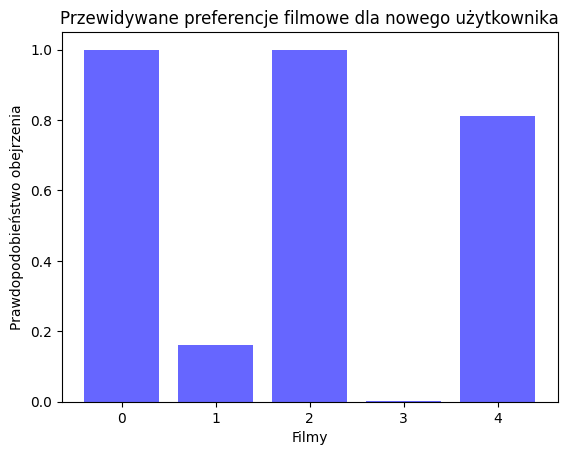

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Klasa RBM z implementacją mechanizmu CD
class RBM:
    def __init__(self, n_visible, n_hidden, learning_rate=0.1):
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.learning_rate = learning_rate  # Szybkość uczenia

        # Inicjalizacja wag i przesunięć
        self.W = np.random.randn(n_visible, n_hidden) * 0.1 
        self.b_visible = np.zeros(n_visible)
        self.b_hidden = np.zeros(n_hidden)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x)) # funkcja aktywacji sigmoidalna -> zamienia wyniku na zakres (0, 1)

    def sample_prob(self, probs):
        """Losowanie stanów (0 lub 1) na podstawie prawdopodobieństw."""
        return np.random.binomial(1, probs) # Zamienia prawdopodobieństwo na 0 lub 1

    def train(self, data, k=1, epochs=10): # k = liczba kroków Gibbsa
        # Trening sieci RBM korzystajac z CD
        for epoch in range(epochs):
            for user in data:
                # Faza pozytywna
                h_prob = self.sigmoid(np.dot(user, self.W) + self.b_hidden)
                h_sample = self.sample_prob(h_prob)
                
                # Faza negatywna (rekonstrukcja)
                for _ in range(k):
                    v_reconstructed_prob = self.sigmoid(np.dot(h_sample, self.W.T) + self.b_visible)
                    v_reconstructed_sample = self.sample_prob(v_reconstructed_prob)
                    h_reconstructed_prob = self.sigmoid(np.dot(v_reconstructed_sample, self.W) + self.b_hidden)
                    h_sample = self.sample_prob(h_reconstructed_prob)
                
                # Aktualizacja wag i przesunięć
                pos_grad = np.outer(user, h_prob)   # Pozytywne skojarzenia
                neg_grad = np.outer(v_reconstructed_sample, h_reconstructed_prob)  # Negatywne skojarzenia
                self.W += self.learning_rate * (pos_grad - neg_grad)
                self.b_visible += self.learning_rate * (user - v_reconstructed_sample)
                self.b_hidden += self.learning_rate * (h_prob - h_reconstructed_prob)

    def predict(self, v_input): # Przewidywanie wartości wizualnej na podstawie reprezentacji ukrytej
        """Przewidywanie wartości wizualnej na podstawie reprezentacji ukrytej."""
        h_prob = self.sigmoid(np.dot(v_input, self.W) + self.b_hidden) # Obliczanie prawdopodobieństw w warstwie ukrytej
        v_reconstructed = self.sigmoid(np.dot(h_prob, self.W.T) + self.b_visible)
        return v_reconstructed

# Przykładowe dane: preferencje filmowe użytkowników (1 = oglądane, 0 = nie oglądane)
movie_data = np.array([
    [1, 0, 1, 0, 1],  # Użytkownik 1
    [0, 1, 0, 1, 0],  # Użytkownik 2
    [1, 1, 1, 0, 0],  # Użytkownik 3
    [0, 0, 1, 1, 1],  # Użytkownik 4
])

# Ustalanie parametrów RBM
n_visible = movie_data.shape[1]  # Liczba filmów
n_hidden = 3  # Liczba neuronów ukrytych
learning_rate = 0.1

# Inicjalizacja i trening RBM
rbm = RBM(n_visible, n_hidden, learning_rate)
rbm.train(movie_data, k=1, epochs=5000)

# Przewidywanie na podstawie ukrytej reprezentacji dla nowego użytkownika
new_user = np.array([1, 0, 1, 0, 0])  # Użytkownik obejrzał filmy 1 i 3
predicted = rbm.predict(new_user)
print("Przewidywane preferencje dla nowego użytkownika:", predicted)

# Rysowanie wykresu przewidywanych preferencji
plt.bar(range(n_visible), predicted, color='blue', alpha=0.6)
plt.xlabel("Filmy")
plt.ylabel("Prawdopodobieństwo obejrzenia")
plt.title("Przewidywane preferencje filmowe dla nowego użytkownika")
plt.show()

#### Zadanie 3
Sieć DBN (Deep Belief Network)
- Przedstawić dowolną, działającą sieć DBN w problemie klasyfikacji/regresji/inżynierii cech.

Sieć DBN - rodzaj głębokiej sieci neuronowej składającej się z kilku warstw ukrytych, gdzie każda warstwa jest w rzeczywistości Restricted Boltzmann Machine (RBM). Świetnie nadaje się do zadań takich jak redukcja szumu, kompresja danych oraz inicjalizacja głębszych sieci neuronowych.

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.neural_network import BernoulliRBM
from sklearn import linear_model
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Wczytanie danych i przygotowanie danych
X, y = load_digits(return_X_y=True)
X = X / 16.0  # Normalizacja danych

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Budowa modelu DBN jako klasyfikatora
rbm1 = BernoulliRBM(n_components=128, learning_rate=0.01, n_iter=100) # 128 neuronów w warstwie ukrytej
rbm2 = BernoulliRBM(n_components=64, learning_rate=0.01, n_iter=100)
logistic = linear_model.LogisticRegression(max_iter=1000)

# Łańcuch RBM i regresji logistycznej
dbn_classifier = Pipeline(steps=[('rbm1', rbm1), ('rbm2', rbm2), ('logistic', logistic)]) # Łączenie modeli w łańcuch 

# Trenowanie modelu
dbn_classifier.fit(X_train, y_train)

# Przewidywanie i ocena dokładności
y_pred = dbn_classifier.predict(X_test)
print(f"Accuracy (classification): {accuracy_score(y_test, y_pred) * 100:.2f}%")

Accuracy (classification): 82.22%


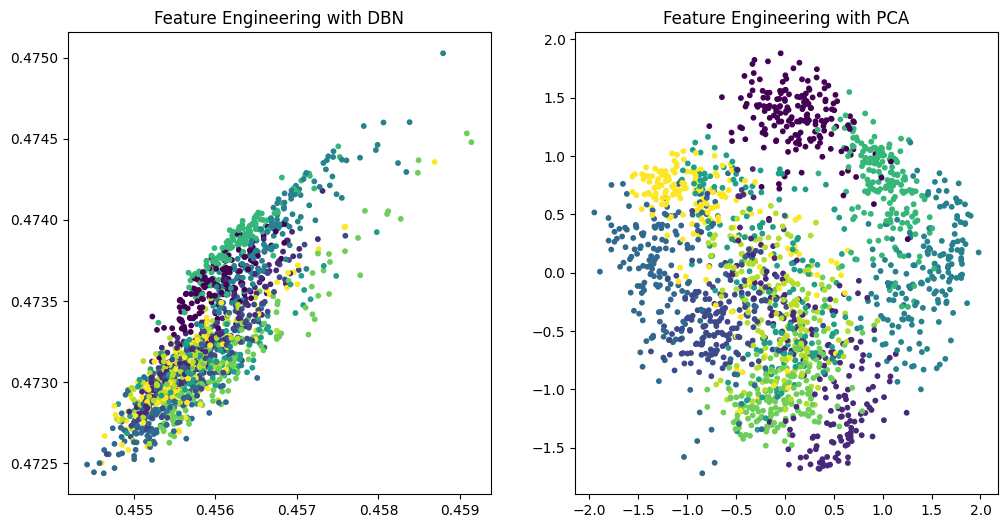

In [9]:
from sklearn.neural_network import BernoulliRBM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# Wczytanie danych i przygotowanie
digits = load_digits()
X, y = digits.data / 16.0, digits.target  # Normalizacja danych

# Podział na zbiór treningowy i testowy (X tylko do pretrainowania warstw RBM)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Warstwa 1 RBM
rbm1 = BernoulliRBM(n_components=128, learning_rate=0.01, n_iter=10, random_state=42)
rbm1.fit(X_train)  # Trening pierwszej warstwy RBM
X_train_transformed = rbm1.transform(X_train)  # Transformacja danych

# Warstwa 2 RBM
rbm2 = BernoulliRBM(n_components=64, learning_rate=0.01, n_iter=10, random_state=42)
rbm2.fit(X_train_transformed)  # Trening drugiej warstwy RBM
X_transformed = rbm2.transform(X_train_transformed)  # Transformacja danych przez RBM2

# Redukcja wymiarów za pomocą PCA dla porównania
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Wykres redukcji wymiarów DBN i PCA
plt.figure(figsize=(12, 6))

# Wykres DBN
plt.subplot(1, 2, 1)
plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=y_train[:X_transformed.shape[0]], cmap='viridis', s=10)
plt.title("Feature Engineering with DBN")

# Wykres PCA
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=10)
plt.title("Feature Engineering with PCA")

plt.show()


In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Wczytanie danych California Housing
data = fetch_california_housing() # Zbiór danych California Housing, 20640 próbek, 8 cech 
X, y = data.data, data.target

# Normalizacja danych
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X = scaler_X.fit_transform(X)
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()  # Przekształcenie `y` do 1D po skalowaniu

# Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Warstwy RBM i model regresji liniowej
rbm1 = BernoulliRBM(n_components=128, learning_rate=0.01, n_iter=10, random_state=42) # 128 neuronów w warstwie ukrytej, n_iter = liczba iteracji
rbm2 = BernoulliRBM(n_components=64, learning_rate=0.01, n_iter=10, random_state=42) # 64 neurony w warstwie ukrytej
regressor = LinearRegression()

# Pipeline DBN jako regresor liniowy do przewidywania wartośco
dbn_regressor = Pipeline(steps=[('rbm1', rbm1), ('rbm2', rbm2), ('linear', regressor)]) 

# Trenowanie modelu
dbn_regressor.fit(X_train, y_train)

# Przewidywanie i ocena MSE
y_pred = dbn_regressor.predict(X_test)
mse = mean_squared_error(scaler_y.inverse_transform(y_test.reshape(-1, 1)), scaler_y.inverse_transform(y_pred.reshape(-1, 1)))
print(f"Mean Squared Error (regression): {mse:.2f}")


Mean Squared Error (regression): 1.05


#### Zadanie 4 

Sieć AE (ang. Autoencoder)
- Zbudować koder i dekoder (autokoder) własnych przykładów (ale nie obrazów). Celem treningu takiego układu jest dobra kompresja modelu, która daje wgląd w tzw. przestrzeń ukrytą cech(latent space). Zwizualizować grupy punktów należące do różnych klas w przestrzeni ukrytej.

- Autoenkoder to rodzaj sztucznej sieci neuronowej, który służy do uczenia się reprezentacji danych (nazywanej kodowaniem) dla zestawu danych. Składa się z dwóch głównych części: enkodera, który uczy się kodować dane wejściowe w reprezentację danych, oraz dekodera, który uczy się dekodować reprezentację danych na oryginalne dane. Jest używany do redukcji wymiarowości, uczenia się cech i ekstrakcji cech.

Algorytm t-SNE:
- używane do przekształcenia danych z przestrzeni ukrytej (latent space) do dwuwymiarowej przestrzeni, aby można je było łatwo wizualizować.

Dlaczego t-SNE?
1. Redukcja wymiarów - t-SNE jest używane do redukcji wymiarów danych, aby można je było łatwo wizualizować.
2. Wizualizacja podobieństw - t-SNE jest używane do wizualizacji podobieństw między punktami - punkty, które są blisko siebie w oryginalnej przestrzeni wielowymiarowej, pozostają blisko siebie w przestrzeni 2D, a punkty bardziej odległe są również od siebie oddzielone.
3. Identyfikacja grup - t-SNE jest używane do identyfikacji grup punktów, które są podobne do siebie.

Intepretacja wykresu t-SNE:
- Punkty, które są blisko siebie w przestrzeni 2D, są podobne do siebie w oryginalnej przestrzeni wielowymiarowej.
- Punkty, które są daleko od siebie w przestrzeni 2D, są różne od siebie w oryginalnej przestrzeni wielowymiarowej. To sugeruje, że model nauczył się wyodrębniać różnice między tymi grupami.

Przenikanie się grup: Jeśli punkty z różnych klas są wymieszane, może to oznaczać, że model ma trudność z rozróżnieniem tych klas w przestrzeni ukrytej, co może wskazywać na potrzebę dalszego dostrojenia modelu.

Epoch 1/50
25/25 [==============================] - 1s 9ms/step - loss: 0.0840 - val_loss: 0.0849
Epoch 2/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0828 - val_loss: 0.0839
Epoch 3/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0816 - val_loss: 0.0829
Epoch 4/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0800 - val_loss: 0.0816
Epoch 5/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0784 - val_loss: 0.0802
Epoch 6/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0768 - val_loss: 0.0788
Epoch 7/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0751 - val_loss: 0.0773
Epoch 8/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0736 - val_loss: 0.0759
Epoch 9/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0722 - val_loss: 0.0747
Epoch 10/50
25/25 [==============================] - 0s 3ms/step - loss: 0.0711 - val_loss: 0.0737
Epoch 11/50
25/25 [

c:\Users\Mikolaj\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Mikolaj\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


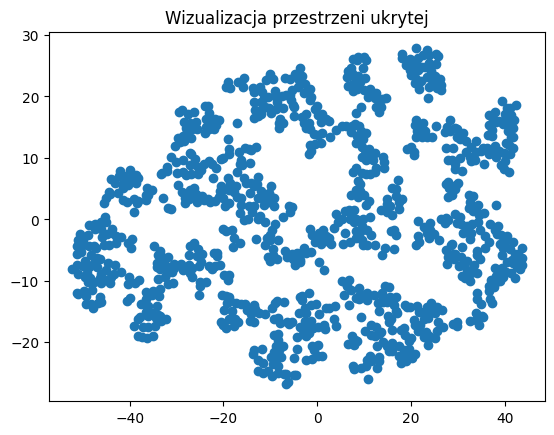

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Przygotowanie danych (przykładowo generowane dane)
data = np.random.rand(1000, 10)  # dane o 10 cechach, 1000 przykładów

# Budowa kodera
input_data = Input(shape=(10,)) # 10 - liczba cech

# Przekształcanie każdej warstwy jest przekształcona przez warstwę Dense z aktywacją relu
encoded = Dense(6, activation='relu')(input_data) # Przekształca z 10 cech do 6 wymiarów
encoded = Dense(3, activation='relu')(encoded)  # przestrzeń ukryta (latent space) o 3 wymiarach

# Budowa dekodera: rekonstrukcja danych wejściowych
decoded = Dense(6, activation='relu')(encoded) # Rekonstrukcja z 6 do 10 cech
decoded = Dense(10, activation='sigmoid')(decoded) # Wartości z zakresu 0-1

# Model autokodera
autoencoder = Model(input_data, decoded)

# Kompilacja i trening
autoencoder.compile(optimizer='adam', loss='mse') # Optymalizator Adam, funkcja straty - średni błąd kwadratowy 
autoencoder.fit(data, data, epochs=50, batch_size=32, validation_split=0.2) 

# Ekstrakcja cech z przestrzeni ukrytej
encoder = Model(input_data, encoded)
latent_space = encoder.predict(data) # Przestrzeń ukryta dla danych wejściowych, 3 wymiary

# Wizualizacja przestrzeni ukrytej za pomocą t-SNE (redukcja do 2D)
latent_space_2d = TSNE(n_components=2).fit_transform(latent_space)
plt.scatter(latent_space_2d[:, 0], latent_space_2d[:, 1])
plt.title("Wizualizacja przestrzeni ukrytej")
plt.show()

#### Zadanie 5
Autokoder obrazów
- Zbudować autokoder obrazów składający się z kodera (N x (Conv2D+MaxPool)) i dekodera (N x Conv2DTranspose), gdzie w każdej z tych części dokonuje się stopniowa kompresja/dekompresja obrazu. W obu częściach sieci zbadać przydatność różnych funkcji aktywacji. Warstwa Keras Conv2Dtranspose działa jak odwrotna konwolucja (nie w sensie matematycznym, tylko funkcjonalnym, tj. z "filtru" robi "obraz"). Przetestować dobroć hiperparametrów na zbiorze
walidacyjnym.

Epoch 1/5
385/385 [==============================] - 27s 67ms/step - loss: 0.1970 - val_loss: 0.0883
Epoch 2/5
385/385 [==============================] - 36s 93ms/step - loss: 0.0837 - val_loss: 0.0796
Epoch 3/5
385/385 [==============================] - 35s 91ms/step - loss: 0.0784 - val_loss: 0.0762
Epoch 4/5
385/385 [==============================] - 32s 82ms/step - loss: 0.0760 - val_loss: 0.0744
Epoch 5/5
313/313 [==============================] - 3s 8ms/step
(10000, 28, 28, 1)


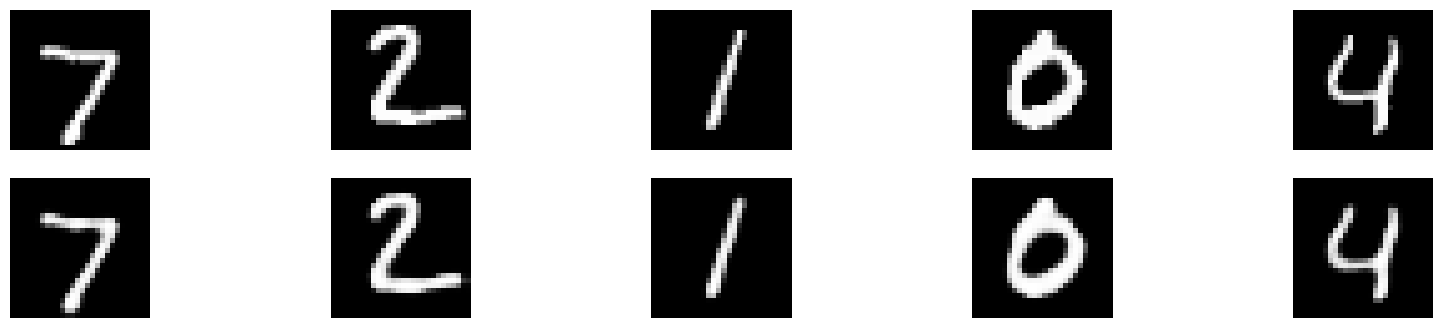

In [8]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Reshape
from tensorflow.keras.datasets import mnist

# Ładowanie i przygotowanie danych obrazów (np. MNIST)
# MNIST = 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255. # Normalizacja wartości pikseli do zakresu 0-1
x_test = x_test.astype('float32') / 255.

# Przygotowuje dane do przetworzenia przez warstwy konwolucyjne, które oczekują wejść z takim wymiarem
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) # Dodanie kanału koloru (1 - grayscale), zdjęcia 28x28
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Budowanie kodera
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = Conv2D(8, (3, 3), activation='relu', padding='same')(x) # Przestrzeń ukryta

# Budowa dekodera
x = Conv2DTranspose(16, (3, 3), activation='relu', strides=(2, 2), padding='same')(encoded)  # (14, 14, 16)
x = Conv2DTranspose(8, (3, 3), activation='relu', strides=(2, 2), padding='same')(x)         # (28, 28, 8)
x = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x) # (28, 28, 1)


# Model autokodera
autoencoder = Model(input_img, x)

# Kompilacja i trening
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=5, batch_size=156, validation_data=(x_test, x_test))

# Testowanie i wizualizacja wyników
decoded_imgs = autoencoder.predict(x_test)

print(decoded_imgs.shape)  # Oczekiwany kształt to (ilość_obrazów_testowych, 28, 28, 1)

# Wizualizacja wyników
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    # Wyświetlanie oryginalnych obrazów
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    
    # Wyświetlanie zdekodowanych obrazów
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()

#### Zadanie 6
Sieć VAE (Variational Autoencoder)
- Zbudować sieć VAE i wygenerować dowolne obiekty z ciągłej przestrzeni ukrytej.

Implementacja sieci VAE:
- Definicja warstw kodera i dekodera,
- Użycie warstw do uzyskania parametrów rozkładu Gaussa (średnia i wariancja) w przestrzeni ukrytej,
- Funkcja kosztu składająca się z rekonstrukcji oraz regularizacji KL-divergence.

Epoch 1/30
938/938 [==============================] - 9s 7ms/step - loss: 0.2800 - val_loss: 0.2632
Epoch 2/30
938/938 [==============================] - 6s 7ms/step - loss: 0.2633 - val_loss: 0.2630
Epoch 3/30
938/938 [==============================] - 7s 7ms/step - loss: 0.2632 - val_loss: 0.2629
Epoch 4/30
938/938 [==============================] - 6s 7ms/step - loss: 0.2632 - val_loss: 0.2631
Epoch 5/30
938/938 [==============================] - 7s 8ms/step - loss: 0.2631 - val_loss: 0.2630
Epoch 6/30
938/938 [==============================] - 8s 8ms/step - loss: 0.2631 - val_loss: 0.2628
Epoch 7/30
938/938 [==============================] - 8s 9ms/step - loss: 0.2630 - val_loss: 0.2628
Epoch 8/30
938/938 [==============================] - 8s 9ms/step - loss: 0.2631 - val_loss: 0.2626
Epoch 9/30
938/938 [==============================] - 8s 9ms/step - loss: 0.2630 - val_loss: 0.2629
Epoch 10/30
938/938 [==============================] - 8s 9ms/step - loss: 0.2630 - val_loss: 0.2627

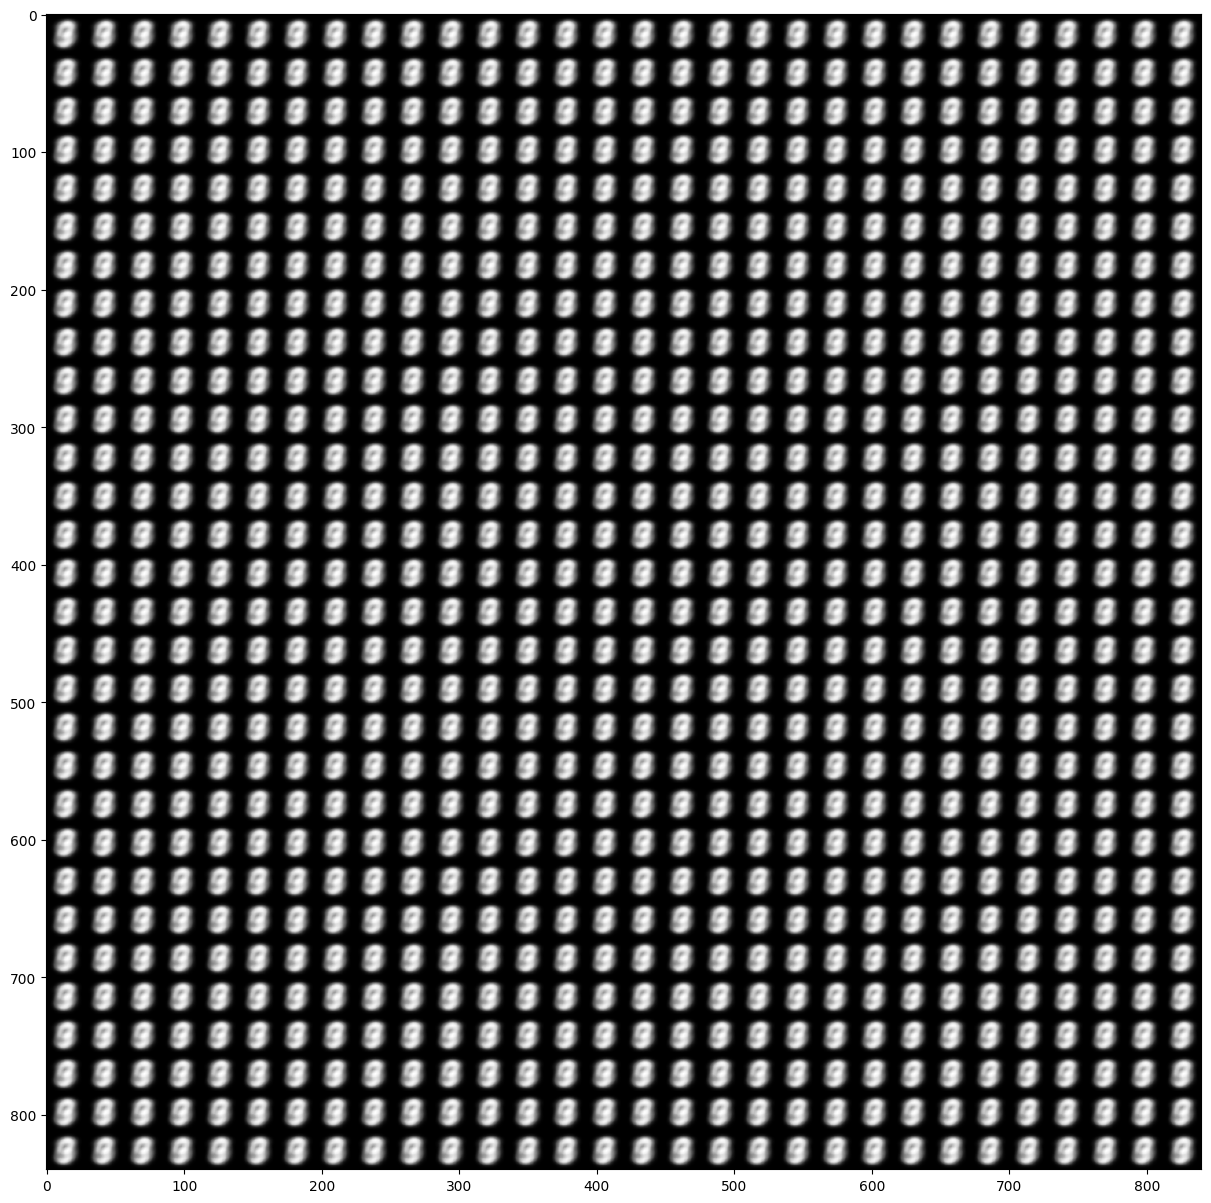

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt

# Ustawienia modelu
latent_dim = 2  # Wymiar przestrzeni ukrytej (latent space)
input_shape = (28, 28, 1)  # Rozmiar danych wejściowych (np. obraz 28x28)

# Koder
class Encoder(Model):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.flatten = layers.Flatten()
        self.dense1 = layers.Dense(128, activation="relu")
        self.dense2 = layers.Dense(64, activation="relu")
        self.mean = layers.Dense(latent_dim)
        self.log_var = layers.Dense(latent_dim)

    def call(self, x):
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        z_mean = self.mean(x) # wektor średnich
        z_log_var = self.log_var(x) # wektor logarytmów wariancji
        return z_mean, z_log_var

# Dekoder
class Decoder(Model):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.dense1 = layers.Dense(64, activation="relu")
        self.dense2 = layers.Dense(128, activation="relu")
        self.dense3 = layers.Dense(28 * 28, activation="sigmoid")
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, z):
        z = self.dense1(z)
        z = self.dense2(z)
        z = self.dense3(z) 
        return self.reshape(z) # Rekonstrukcja obrazu

# Model VAE
class VAE(Model):
    def __init__(self, encoder, decoder, latent_dim):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.latent_dim = latent_dim

    def sample(self, z_mean, z_log_var):
        epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], self.latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def call(self, x):
        z_mean, z_log_var = self.encoder(x) # Obliczanie średnich i logarytmów wariancji
        z = self.sample(z_mean, z_log_var) 
        reconstructed = self.decoder(z) # Rekonstrukcja obrazu
        
        # Obliczanie strat
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, reconstructed))
        kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        
        # Dodanie strat do całkowitej straty modelu
        total_loss = reconstruction_loss + kl_loss
        self.add_loss(total_loss)
        
        return reconstructed

# Kompilacja i trening modelu
encoder = Encoder(latent_dim)
decoder = Decoder(latent_dim)
vae = VAE(encoder, decoder, latent_dim)

# Kompilacja modelu VAE
vae.compile(optimizer='adam')

# Załadowanie danych MNIST
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)
x_test = x_test.astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1)

# Trening modelu
vae.fit(x_train, x_train, epochs=30, batch_size=64, validation_data=(x_test, x_test))

# Generowanie nowych przykładów z przestrzeni ukrytej
def plot_latent_space(vae, n=30, figsize=15):
    digit_size = 28
    scale = 2.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

# Rysowanie wygenerowanych obrazów
plot_latent_space(vae)